In [1]:
import numpy as np
from skimage import io, draw, color, morphology, data
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from skimage.draw import polygon

In [5]:
lower_threshold_cd4 = 10;
upper_threshold_cd4 = 255;
lower_threshold_cd8 = 10;
upper_threshold_cd8 = 255;
lower_threshold_insulin = 10;
upper_threshold_insulin = 255;
lower_threshold_glucagon = 10;
upper_threshold_glucagon = 255;
islet_outlier_size = 5;

def _scale_region(image, region):
    polygon = np.array(region)
    polygon[:,0] = polygon[: ,0] * image.shape[0]
    polygon[:,1] = polygon[: ,1] * image.shape[1]
    return polygon

def _mask_image(image, region):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    polygon = _scale_region(image, region)
    rr, cc = draw.polygon(polygon[:, 1], polygon[:, 0], mask.shape)
    mask[rr, cc] = 255
    masked_image = image.copy()
    masked_image[mask == 0] = 0
    return masked_image

def _compute_masked_image_stats(masked_image):
    pixels = masked_image.reshape(image.shape[0] * image.shape[1], 3)
    ix = np.nonzero(np.any(pixels, axis=1))[0]
    return pixels[ix].mean(axis=0), pixels[ix].std(axis=0)

def _compute_subtraction_value(means, stds):
    return means + 3 * stds

def subtract_background(image, region):
    masked_image = _mask_image(image, region)
    means, stds = _compute_masked_image_stats(masked_image)
    subtraction_value = _compute_subtraction_value(means, stds)
    modified_image = image - subtraction_value
    return np.clip(modified_image, 0, 255).astype(np.uint8)

def save_image(name, image):
    io.imsave(name, image)

def _convert_to_mask(image, lower_threshold, upper_threshold):
    image[image < lower_threshold] = 0
    mask = color.rgb2gray(image)
    return mask > 0

def _combine_images(image1, image2):
    combined_image = np.logical_or(image1, image2)
    return combined_image

def _remove_small_objects_and_holes(image):
    object_size = islet_outlier_size = (5**5) * 3.14
    cleaned_image = morphology.remove_small_objects(image, object_size)
    cleaned_image = morphology.remove_small_holes(cleaned_image, object_size * 4)
    return cleaned_image

def _create_insulin_glucagon_mask(insulin_image, glucagon_image):
    masked_insulin = _convert_to_mask(insulin_image, lower_threshold_insulin, upper_threshold_insulin)
    masked_glucagon = _convert_to_mask(glucagon_image, lower_threshold_glucagon, upper_threshold_glucagon)
    combined_mask = _combine_images(masked_insulin, masked_glucagon)
    cleaned_mask = _remove_small_objects_and_holes(combined_mask)
    return cleaned_mask

def _mask_to_points(mask):
    points = np.argwhere(mask).astype(np.float32)
    return points

def _compute_convex_hull(points):
    if points.shape[0] < 3:
        raise ValueError("Not enough points to form a convex hull.")
    hull = ConvexHull(points)
    return hull

def _save_simplex_plot(image, ins_gluc_points, hull):
    width_px = image.shape[0]
    height_px = image.shape[1]
    dpi = 72
    width_inch = width_px / dpi
    height_inch = height_px / dpi

    mask = np.zeros_like(image, dtype=np.uint8)
    rr, cc = polygon(ins_gluc_points[hull.vertices, 0], ins_gluc_points[hull.vertices, 1], mask.shape)
    mask[rr, cc] = 1

    dimmed_image = image.copy()
    dimmed_image[mask == 0] = (dimmed_image[mask == 0] * 0.5).astype(image.dtype)

    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    plt.imshow(dimmed_image)
    for simplex in hull.simplices:
        plt.plot(ins_gluc_points[simplex, 1], ins_gluc_points[simplex, 0], 'w-')
    plt.axis('off')
    plt.savefig('simplex.png', bbox_inches='tight', pad_inches=0, dpi=dpi)
    plt.show()


def save_convex_hull_overlay(overlay, insulin, glucagon, crop_region):
    ins_gluc_mask = _create_insulin_glucagon_mask(insulin, glucagon)
    cropped_ins_gluc_mask = _mask_image(ins_gluc_mask, crop_region)
    ins_gluc_points = _mask_to_points(cropped_ins_gluc_mask)
    hull = _compute_convex_hull(ins_gluc_points)
    _save_simplex_plot(overlay, ins_gluc_points, hull)
    return hull, ins_gluc_points

def save_mask_cd4_cd8(cd4, cd8, crop_region, hull, ins_gluc_points):
    masked_cd4 = _convert_to_mask(cd4, lower_threshold_cd4, upper_threshold_cd4)
    masked_cd4 = _mask_image(masked_cd4, crop_region)
    color_cd4 = np.zeros((masked_cd4.shape[0], masked_cd4.shape[1], 3), dtype=np.uint8)
    color_cd4[masked_cd4] = [0, 0, 255]
    
    masked_cd8 = _convert_to_mask(cd8, lower_threshold_cd8, upper_threshold_cd8)
    masked_cd8 = _mask_image(masked_cd8, crop_region)
    color_cd8 = np.zeros((masked_cd4.shape[0], masked_cd4.shape[1], 3), dtype=np.uint8)
    color_cd8[masked_cd8] = [255, 0, 0]
    combined_mask = color_cd8 + color_cd4

    width_px = combined_mask.shape[0]
    height_px = combined_mask.shape[1]
    dpi = 72
    width_inch = width_px / dpi
    height_inch = height_px / dpi

    mask = np.zeros_like(combined_mask, dtype=np.uint8)
    rr, cc = polygon(ins_gluc_points[hull.vertices, 0], ins_gluc_points[hull.vertices, 1], mask.shape)
    mask[rr, cc] = 1

    dimmed_image = combined_mask.copy()
    dimmed_image[mask == 0] = (dimmed_image[mask == 0] * 0.5).astype(combined_mask.dtype)

    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    plt.imshow(dimmed_image)
    for simplex in hull.simplices:
        plt.plot(ins_gluc_points[simplex, 1], ins_gluc_points[simplex, 0], 'w-')
    plt.axis('off')
    plt.savefig('inflamation.png', bbox_inches='tight', pad_inches=0, dpi=dpi)
    plt.show()
    

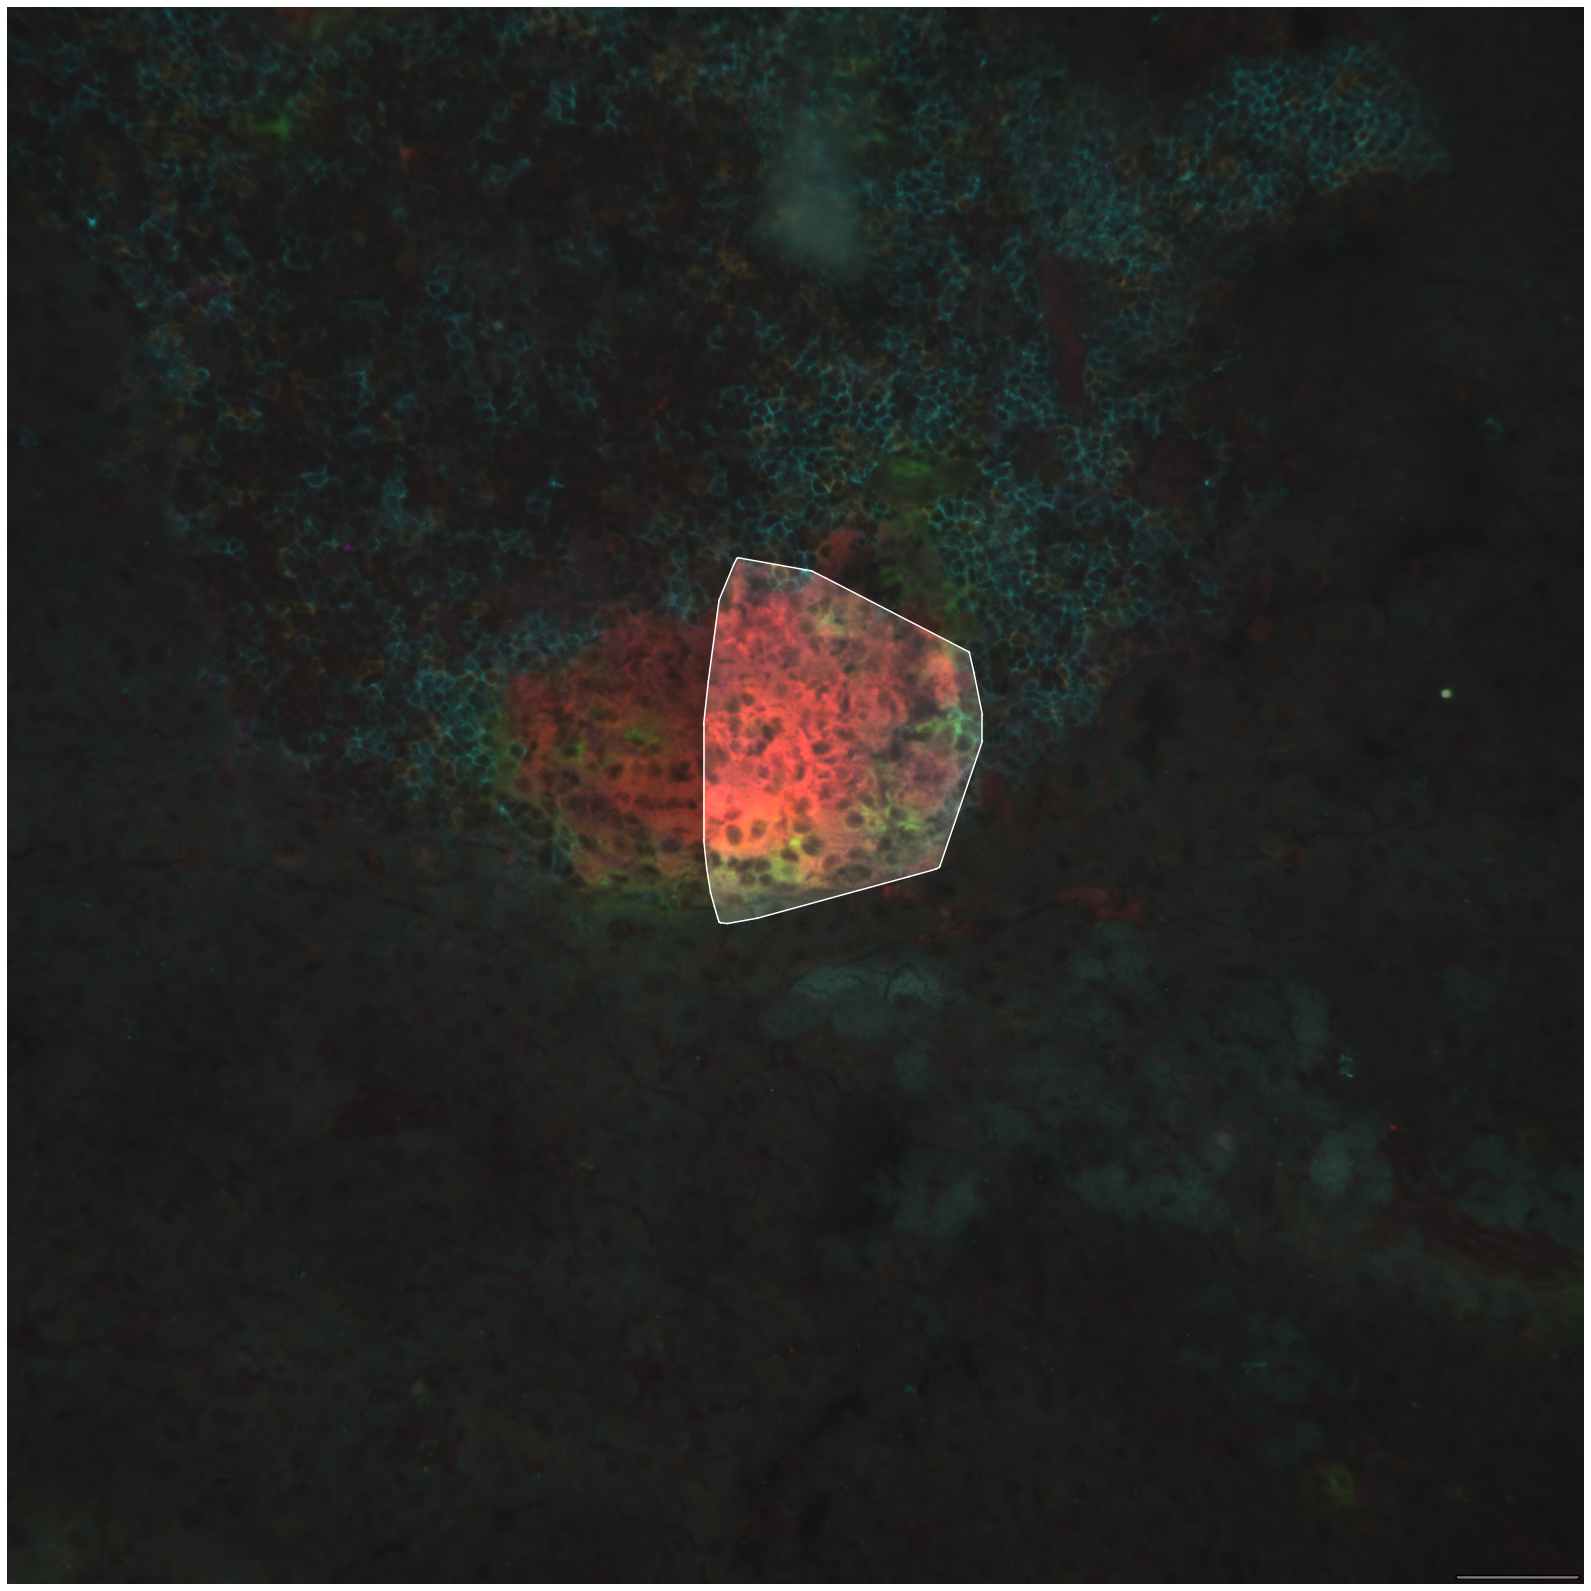

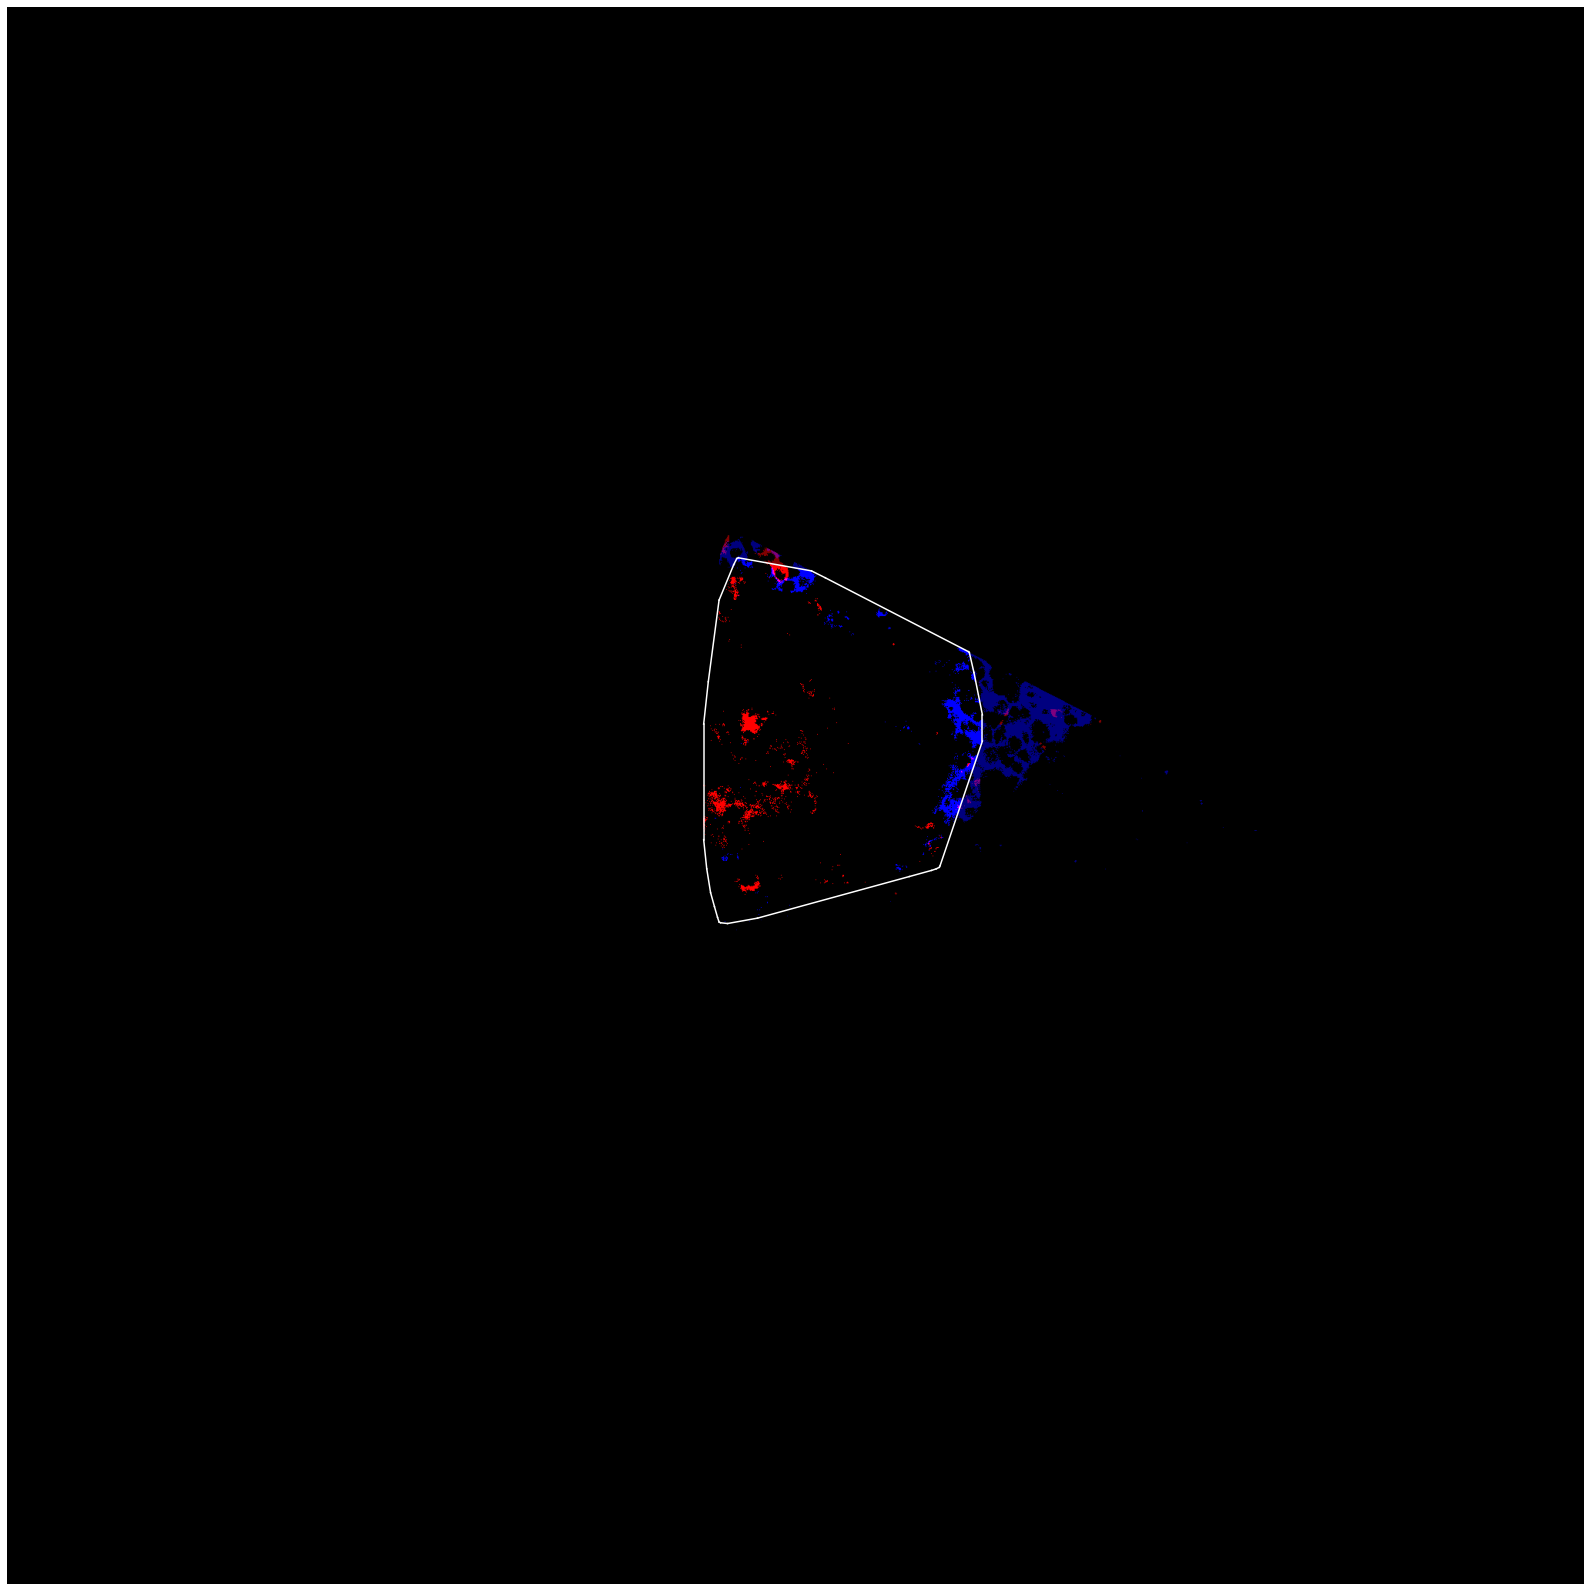

In [7]:
crop_region = [[0.04136439732142857, 0.09972985998376624], [0.04136439732142857, 0.10038935673701299], [0.04136439732142857, 0.10104885349025974], [0.04202389407467533, 0.10104885349025974], [0.04202389407467533, 0.10236784699675325], [0.04202389407467533, 0.10302734375], [0.04202389407467533, 0.1043463372564935], [0.04202389407467533, 0.10500583400974026], [0.04202389407467533, 0.10566533076298701], [0.04202389407467533, 0.10632482751623376], [0.04202389407467533, 0.10698432426948051], [0.04268339082792208, 0.10764382102272728], [0.04268339082792208, 0.10830331777597403], [0.04268339082792208, 0.10962231128246754], [0.04268339082792208, 0.11094130478896104], [0.04268339082792208, 0.11160080154220779], [0.04268339082792208, 0.11226029829545454], [0.04268339082792208, 0.11357929180194805], [0.04334288758116883, 0.1142387885551948], [0.04334288758116883, 0.1155577820616883], [0.04334288758116883, 0.11621727881493507], [0.04334288758116883, 0.11687677556818182], [0.044002384334415584, 0.11819576907467533], [0.044002384334415584, 0.11885526582792208], [0.044002384334415584, 0.12017425933441558], [0.044002384334415584, 0.12149325284090909], [0.044661881087662336, 0.12215274959415584], [0.044661881087662336, 0.12347174310064934], [0.04532137784090909, 0.1241312398538961], [0.04598087459415585, 0.1267692268668831], [0.04598087459415585, 0.1280882203733766], [0.0466403713474026, 0.12940721387987014], [0.0466403713474026, 0.1300667106331169], [0.04729986810064935, 0.1313857041396104], [0.04729986810064935, 0.13429636769480519], [0.047959364853896104, 0.1356153612012987], [0.047959364853896104, 0.1369343547077922], [0.048618861607142856, 0.13759385146103897], [0.048618861607142856, 0.13891284496753248], [0.04927835836038961, 0.14023183847402598], [0.04993785511363636, 0.1415508319805195], [0.05059735186688312, 0.1441888189935065], [0.05059735186688312, 0.1455078125], [0.05125684862012987, 0.1468268060064935], [0.05125684862012987, 0.148145799512987], [0.051916345373376624, 0.14880529626623376], [0.051916345373376624, 0.15012428977272727], [0.052575842126623376, 0.15144328327922077], [0.052575842126623376, 0.1540812702922078], [0.05323533887987013, 0.1554002637987013], [0.05323533887987013, 0.15671925730519481], [0.05389483563311688, 0.15803825081168832], [0.05389483563311688, 0.15935724431818182], [0.05455433238636364, 0.16067623782467533], [0.05521382913961039, 0.16199523133116883], [0.05618405032467533, 0.16490589488636365], [0.05684354707792208, 0.16622488839285715], [0.05684354707792208, 0.16913555194805194], [0.05750304383116883, 0.17045454545454544], [0.05847326501623377, 0.17336520900974026], [0.059443486201298704, 0.17627587256493507], [0.06041370738636364, 0.17918653612012986], [0.062354149756493504, 0.18209719967532467], [0.06332437094155845, 0.1850078632305195], [0.06639990868506493, 0.19116528003246752], [0.06737012987012987, 0.19407594358766234], [0.06931057224025974, 0.19698660714285715], [0.07028079342532467, 0.19989727069805194], [0.07375583400974026, 0.20896535105519481], [0.07569627637987013, 0.2118760146103896], [0.07877181412337662, 0.21803343141233766], [0.08224685470779221, 0.2271015117694805], [0.0853223924512987, 0.23325892857142858], [0.08685699066558442, 0.2394163453733766], [0.09300806615259741, 0.2517311789772727], [0.09494850852272728, 0.2546418425324675], [0.09802404626623376, 0.2607992593344156], [0.09996448863636363, 0.26370992288961037], [0.10149908685064934, 0.26986733969155846], [0.10343952922077922, 0.2727780032467532], [0.10537997159090909, 0.27568866680194803], [0.10732041396103896, 0.27859933035714285], [0.10926085633116883, 0.28150999391233766], [0.11023107751623376, 0.2844206574675325], [0.11217151988636363, 0.2873313210227273], [0.11349051339285714, 0.2886503145292208], [0.11446073457792208, 0.2915609780844156], [0.11640117694805195, 0.29447164163961037], [0.11772017045454546, 0.2957906351461039], [0.11966061282467533, 0.2987012987012987], [0.12063083400974026, 0.3016119622564935], [0.12194982751623376, 0.302930955762987], [0.12389026988636363, 0.3058416193181818], [0.12454976663961038, 0.3071606128246753], [0.12649020900974026, 0.31007127637987014], [0.12843065137987014, 0.31298193993506496], [0.1290901481331169, 0.31430093344155846], [0.13103059050324675, 0.3172115969967532], [0.1329710328733766, 0.32012226055194803], [0.13429002637987014, 0.32144125405844154], [0.13623046875, 0.32435191761363635], [0.13720068993506493, 0.32726258116883117], [0.13851968344155843, 0.3285815746753247], [0.14046012581168832, 0.3314922382305195], [0.14240056818181818, 0.3344029017857143], [0.14434101055194806, 0.3373135653409091], [0.14628145292207792, 0.3402242288961039], [0.1482218952922078, 0.3431348924512987], [0.15016233766233766, 0.3460455560064935], [0.15210278003246752, 0.3489562195616883], [0.1540432224025974, 0.35186688311688313], [0.15470271915584416, 0.35318587662337664], [0.15664316152597402, 0.35609654017857145], [0.16228693181818182, 0.3636236810064935], [0.16325715300324675, 0.3665343445616883], [0.1651975953733766, 0.36944500811688313], [0.1671380377435065, 0.37235567167207795], [0.16907848011363635, 0.3752663352272727], [0.17101892248376624, 0.3781769987824675], [0.1729593648538961, 0.38108766233766234], [0.1786031351461039, 0.3886148031655844], [0.18054357751623376, 0.3915254667207792], [0.18361911525974026, 0.3976828835227273], [0.18823559253246752, 0.40229936079545453], [0.1932515726461039, 0.4113674411525974], [0.19519201501623376, 0.4142781047077922], [0.19980849228896103, 0.4188945819805195], [0.20545226258116883, 0.42642172280844154], [0.2073927049512987, 0.42933238636363635], [0.21046824269480519, 0.4354898031655844], [0.21508471996753248, 0.4401062804383117], [0.21702516233766234, 0.4430169439935065], [0.2216416396103896, 0.4476334212662338], [0.2235820819805195, 0.45054408482142855], [0.22819855925324675, 0.45516056209415584], [0.23127409699675325, 0.4613179788961039], [0.23418476055194806, 0.4632584212662338], [0.23612520292207792, 0.46616908482142855], [0.2380656452922078, 0.46907974837662336], [0.24268212256493507, 0.47369622564935066], [0.24462256493506493, 0.47660688920454547], [0.24656300730519481, 0.4795175527597403], [0.2494736708603896, 0.48145799512987014], [0.2514141132305195, 0.48436865868506496], [0.252733106737013, 0.48568765219155846], [0.2540521002435065, 0.48700664569805197], [0.25599254261363635, 0.4899173092532468], [0.25797103287337664, 0.4925552962662338], [0.25929002637987014, 0.4938742897727273], [0.26060901988636365, 0.4951932832792208], [0.26192801339285715, 0.4965122767857143], [0.2625875101461039, 0.497171773538961], [0.2639065036525974, 0.49849076704545453], [0.26456600040584416, 0.4991502637987013], [0.2652254971590909, 0.49980976055194803], [0.26588499391233766, 0.5011287540584416], [0.2665444906655844, 0.5017882508116883], [0.26786348417207795, 0.502447747564935], [0.26786348417207795, 0.5031072443181818], [0.26918247767857145, 0.5037667410714286], [0.2698419744318182, 0.5044262378246753], [0.27050147118506496, 0.505085734577922], [0.2711609679383117, 0.505085734577922], [0.27182046469155846, 0.5057452313311688], [0.2724799614448052, 0.5064047280844156], [0.2724799614448052, 0.5070642248376623], [0.27313945819805197, 0.5077237215909091], [0.2737989549512987, 0.5077237215909091], [0.27445845170454547, 0.5083832183441559], [0.2751179484577922, 0.5090427150974026], [0.275777445211039, 0.5097022118506493], [0.2764369419642857, 0.5103617086038961], [0.2770964387175325, 0.5110212053571429], [0.2777559354707792, 0.5116807021103896], [0.278415432224026, 0.5123401988636364], [0.2790749289772727, 0.5129996956168831], [0.2803939224837662, 0.5136591923701299], [0.281053419237013, 0.5143186891233766], [0.2823724127435065, 0.5149781858766234], [0.2830319094967532, 0.5156376826298701], [0.28369140625, 0.5169566761363636], [0.2843509030032468, 0.5176161728896104], [0.2856698965097403, 0.5182756696428571], [0.286329393262987, 0.5189351663961039], [0.2876483867694805, 0.5195946631493507], [0.2883078835227273, 0.5209136566558441], [0.2896268770292208, 0.5215731534090909], [0.2902863737824675, 0.5222326501623377], [0.2909458705357143, 0.5228921469155844], [0.2922648640422078, 0.5235516436688312], [0.29292436079545453, 0.5248706371753247], [0.29424335430194803, 0.5255301339285714], [0.2949028510551948, 0.5261896306818182], [0.2962218445616883, 0.526849127435065], [0.29688134131493504, 0.5275086241883117], [0.2975408380681818, 0.5281681209415584], [0.29820033482142855, 0.5288276176948052], [0.29951932832792205, 0.529487114448052], [0.30017882508116883, 0.5301466112012987], [0.3008383218344156, 0.5308061079545454], [0.3021573153409091, 0.5314656047077922], [0.30281681209415584, 0.532125101461039], [0.3034763088474026, 0.532125101461039], [0.30413580560064934, 0.5327845982142857], [0.30545479910714285, 0.5334440949675324], [0.30611429586038963, 0.5334440949675324], [0.30677379261363635, 0.5341035917207793], [0.30743328936688313, 0.534763088474026], [0.30809278612012986, 0.534763088474026], [0.30875228287337664, 0.5354225852272727], [0.30941177962662336, 0.5360820819805194], [0.31073077313311687, 0.5360820819805194], [0.31139026988636365, 0.5367415787337663], [0.31204976663961037, 0.537401075487013], [0.31270926339285715, 0.537401075487013], [0.31402825689935066, 0.5380605722402597], [0.3146877536525974, 0.5380605722402597], [0.3160067471590909, 0.5387200689935064], [0.31666624391233766, 0.5387200689935064], [0.31798523741883117, 0.5393795657467533], [0.31864473417207795, 0.5393795657467533], [0.3193042309253247, 0.5400390625], [0.3206232244318182, 0.5406985592532467], [0.3219422179383117, 0.5406985592532467], [0.32260171469155846, 0.5413580560064936], [0.32392070819805197, 0.5413580560064936], [0.32523970170454547, 0.5413580560064936], [0.3258991984577922, 0.5420175527597403], [0.3272181919642857, 0.542677049512987], [0.3285371854707792, 0.542677049512987], [0.3298561789772727, 0.5433365462662337], [0.3311751724837662, 0.5433365462662337], [0.3324941659902597, 0.5439960430194806], [0.3331536627435065, 0.5439960430194806], [0.33447265625, 0.5446555397727273], [0.3357916497564935, 0.5446555397727273], [0.3364511465097403, 0.545315036525974], [0.3377701400162338, 0.545315036525974], [0.3390891335227273, 0.5459745332792207], [0.3404081270292208, 0.5466340300324676], [0.3417271205357143, 0.5466340300324676], [0.3430461140422078, 0.5472935267857143], [0.3443651075487013, 0.5472935267857143], [0.34502460430194803, 0.547953023538961], [0.34634359780844154, 0.5486125202922078], [0.34766259131493504, 0.5486125202922078], [0.34898158482142855, 0.5492720170454546], [0.35030057832792205, 0.5492720170454546], [0.3516195718344156, 0.5499315137987013], [0.3529385653409091, 0.550591010551948], [0.3542575588474026, 0.550591010551948], [0.35491705560064934, 0.5512505073051948], [0.35623604910714285, 0.5512505073051948], [0.35914671266233766, 0.5522207284902597], [0.36046570616883117, 0.5528802252435064], [0.3617846996753247, 0.5528802252435064], [0.3646953632305195, 0.5538504464285714], [0.366014356737013, 0.5545099431818182], [0.3673333502435065, 0.5545099431818182], [0.36865234375, 0.555169439935065], [0.3699713372564935, 0.5558289366883117], [0.3728820008116883, 0.5558289366883117], [0.3742009943181818, 0.5564884334415584], [0.3755199878246753, 0.5564884334415584], [0.37843065137987014, 0.5574586546266234], [0.37974964488636365, 0.5581181513798701], [0.38106863839285715, 0.5581181513798701], [0.38238763189935066, 0.5587776481331169], [0.38529829545454547, 0.5597478693181818], [0.386617288961039, 0.5604073660714286], [0.3879362824675325, 0.5604073660714286], [0.3908469460227273, 0.5613775872564936], [0.3921659395292208, 0.5620370840097403], [0.3934849330357143, 0.562696580762987], [0.3963955965909091, 0.562696580762987], [0.3993062601461039, 0.563666801948052], [0.4006252536525974, 0.5643262987012987], [0.4019442471590909, 0.5649857954545454], [0.4032632406655844, 0.5656452922077922], [0.4061739042207792, 0.5656452922077922], [0.4074928977272727, 0.566304788961039], [0.4104035612824675, 0.5672750101461039], [0.411722554788961, 0.5679345068993507], [0.41304154829545453, 0.5685940036525974], [0.41436054180194803, 0.5685940036525974], [0.41567953530844154, 0.5692535004058441], [0.41859019886363635, 0.5702237215909091], [0.41990919237012986, 0.5702237215909091], [0.42056868912337664, 0.5708832183441559], [0.42188768262987014, 0.5708832183441559], [0.42320667613636365, 0.5715427150974026], [0.42452566964285715, 0.5715427150974026], [0.4251851663961039, 0.5722022118506493], [0.4265041599025974, 0.5722022118506493], [0.42716365665584416, 0.5728617086038961], [0.42848265016233766, 0.5728617086038961], [0.4291421469155844, 0.5735212053571429], [0.43046114042207795, 0.5735212053571429], [0.43178013392857145, 0.5735212053571429], [0.4324396306818182, 0.5741807021103896], [0.4337586241883117, 0.5741807021103896], [0.43441812094155846, 0.5741807021103896], [0.43573711444805197, 0.5748401988636364], [0.43705610795454547, 0.5748401988636364], [0.438375101461039, 0.5754996956168831], [0.4396940949675325, 0.5754996956168831], [0.441013088474026, 0.5754996956168831], [0.4439237520292208, 0.576469916801948], [0.4452427455357143, 0.576469916801948], [0.4465617390422078, 0.576469916801948], [0.4494724025974026, 0.576469916801948], [0.4507913961038961, 0.5771294135551948], [0.4537020596590909, 0.5771294135551948], [0.4566127232142857, 0.5771294135551948], [0.4579317167207792, 0.5771294135551948], [0.460842380275974, 0.5771294135551948], [0.4621613737824675, 0.5771294135551948], [0.46507203733766234, 0.5771294135551948], [0.46798270089285715, 0.5771294135551948], [0.46930169439935066, 0.5771294135551948], [0.47221235795454547, 0.5771294135551948], [0.4764420150162338, 0.5771294135551948], [0.47935267857142855, 0.5771294135551948], [0.48226334212662336, 0.5771294135551948], [0.4851740056818182, 0.5761528510551948], [0.4864929991883117, 0.5761528510551948], [0.4894036627435065, 0.5761528510551948], [0.4923143262987013, 0.5751762885551948], [0.4952249898538961, 0.5751762885551948], [0.4981356534090909, 0.5751762885551948], [0.5010463169642857, 0.5741997260551948], [0.5039569805194806, 0.5741997260551948], [0.505275974025974, 0.573533887987013], [0.5081866375811688, 0.573533887987013], [0.5110973011363636, 0.572557325487013], [0.5140079646915584, 0.572557325487013], [0.5169186282467533, 0.571580762987013], [0.5182376217532467, 0.571580762987013], [0.5195566152597403, 0.5709149249188312], [0.522467278814935, 0.5709149249188312], [0.5237862723214286, 0.5702490868506493], [0.525105265827922, 0.5695832487824676], [0.5280159293831169, 0.5686066862824676], [0.5293349228896104, 0.5686066862824676], [0.5306539163961039, 0.5679408482142857], [0.5319729099025974, 0.5672750101461039], [0.5332919034090909, 0.566609172077922], [0.5346108969155844, 0.5659433340097403], [0.535929890422078, 0.5652774959415584], [0.5372488839285714, 0.5639521611201299], [0.538567877435065, 0.563286323051948], [0.5398868709415584, 0.5619609882305194], [0.541205864448052, 0.5612951501623377], [0.5425248579545454, 0.5599698153409091], [0.543843851461039, 0.5586444805194806], [0.5451628449675324, 0.5579786424512987], [0.5480735085227273, 0.5560318587662337], [0.5493925020292207, 0.555366020698052], [0.5523031655844156, 0.553419237012987], [0.5536221590909091, 0.5520939021915584], [0.5549411525974026, 0.5507685673701299], [0.5578518161525974, 0.5497920048701299], [0.5591708096590909, 0.5484666700487013], [0.5620814732142857, 0.5474901075487013], [0.5634004667207793, 0.5461647727272727], [0.566311130275974, 0.5451882102272727], [0.5692217938311688, 0.5442116477272727], [0.5705407873376623, 0.5435458096590909], [0.5734514508928571, 0.541599025974026], [0.576362114448052, 0.540622463474026], [0.5776811079545454, 0.5399566254058441], [0.5805917715097403, 0.5389800629058441], [0.5819107650162337, 0.5383142248376623], [0.5880681818181818, 0.5367732853084416], [0.5893871753246753, 0.5361074472402597], [0.5922978388798701, 0.5341606635551948], [0.5936168323863636, 0.5341606635551948], [0.5965274959415584, 0.5322138798701299], [0.5994381594967533, 0.5312373173701299], [0.6007571530032467, 0.5312373173701299], [0.6036678165584416, 0.529290533685065], [0.604986810064935, 0.5286246956168831], [0.6063058035714286, 0.5279588575487013], [0.607624797077922, 0.5272930194805194], [0.6105354606331169, 0.5263164569805194], [0.6111949573863636, 0.5256506189123377], [0.6125139508928571, 0.5249847808441559], [0.6138329443993507, 0.524318942775974], [0.6151519379058441, 0.5229936079545454], [0.6164709314123377, 0.5223277698863636], [0.6177899249188312, 0.5216619318181818], [0.6191089184253247, 0.5203365969967533], [0.6197684151785714, 0.5196707589285714], [0.621087408685065, 0.5183454241071429], [0.6217469054383117, 0.517679586038961], [0.6230658989448052, 0.5163542512175324], [0.623725395698052, 0.5156884131493507], [0.6243848924512987, 0.514363078327922], [0.6250443892045454, 0.5130377435064936], [0.626363382711039, 0.5123719054383117], [0.6270228794642857, 0.5110465706168831], [0.6276823762175324, 0.5097212357954546], [0.6283418729707793, 0.508395900974026], [0.6296608664772727, 0.5070705661525974], [0.6296608664772727, 0.5041535612824676], [0.6309798599837663, 0.502828226461039], [0.6319500811688312, 0.4999112215909091], [0.633890523538961, 0.4969942167207792], [0.634860744724026, 0.49407721185064934], [0.6355202414772727, 0.4927518770292208], [0.6370548396915584, 0.48658811891233766], [0.6389952820616883, 0.4836711140422078], [0.6399655032467533, 0.48075410917207795], [0.6409357244318182, 0.47783710430194803], [0.6440112621753247, 0.47167334618506496], [0.6449814833603896, 0.46875634131493504], [0.6463004768668831, 0.4674310064935065], [0.647270698051948, 0.46451400162337664], [0.648240919237013, 0.4615969967532468], [0.649211140422078, 0.45867999188311687], [0.6511515827922078, 0.455762987012987], [0.6518110795454546, 0.45443765219155846], [0.6524705762987013, 0.45311231737012986], [0.653130073051948, 0.4517869825487013], [0.6544490665584416, 0.4504616477272727], [0.6554192877435064, 0.44754464285714285], [0.6560787844967533, 0.4462193080357143], [0.6573977780032467, 0.4448939732142857], [0.6580572747564936, 0.4442281351461039], [0.6587167715097403, 0.4429028003246753], [0.659376268262987, 0.4415774655032468], [0.6606952617694806, 0.44091162743506496], [0.6613547585227273, 0.43958629261363635], [0.662014255275974, 0.43892045454545453], [0.6626737520292207, 0.437595119724026], [0.6639927455357143, 0.43692928165584416], [0.6639927455357143, 0.4356039468344156], [0.6653117390422078, 0.4349381087662338], [0.6659712357954546, 0.43427227069805197], [0.6659712357954546, 0.43360643262987014], [0.667290229301948, 0.43228109780844154], [0.667290229301948, 0.4316152597402597], [0.6686092228084416, 0.43094942167207795], [0.6686092228084416, 0.42962408685064934], [0.6692687195616883, 0.4289582487824675], [0.669928216314935, 0.4282924107142857], [0.6705877130681818, 0.42696707589285715], [0.6705877130681818, 0.42564174107142855], [0.6719067065746753, 0.4249759030032468], [0.6719067065746753, 0.4236505681818182], [0.672566203327922, 0.42232523336038963], [0.6732257000811688, 0.420999898538961], [0.6738851968344156, 0.4196745637175325], [0.6745446935876623, 0.4183492288961039], [0.6752041903409091, 0.4170238940746753], [0.676174411525974, 0.41410688920454547], [0.6768339082792207, 0.41278155438311687], [0.6778041294642857, 0.409864549512987], [0.6784636262175324, 0.40853921469155846], [0.6794338474025974, 0.40562220982142855], [0.6804040685876623, 0.4027052049512987], [0.6823445109577922, 0.39978820008116883], [0.683004007711039, 0.3984628652597403], [0.6839742288961039, 0.39554586038961037], [0.6859146712662337, 0.3926288555194805], [0.6865741680194806, 0.39130352069805197], [0.6875443892045454, 0.38838651582792205], [0.6894848315746753, 0.3854695109577922], [0.690144328327922, 0.38414417613636365], [0.692084770698052, 0.3812271712662338], [0.6927442674512987, 0.3799018364448052], [0.6946847098214286, 0.3769848315746753], [0.6953442065746753, 0.3756594967532468], [0.6966632000811688, 0.3743341619318182], [0.6973226968344156, 0.37300882711038963], [0.6982929180194806, 0.3700918222402597], [0.699611911525974, 0.36876648741883117], [0.7002714082792207, 0.3674411525974026], [0.7015904017857143, 0.366115817775974], [0.702249898538961, 0.36479048295454547], [0.7029093952922078, 0.36346514813311687], [0.7042283887987013, 0.3621398133116883], [0.704887885551948, 0.3608144784902597], [0.7055473823051948, 0.35948914366883117], [0.7068663758116883, 0.3581638088474026], [0.707525872564935, 0.356838474025974], [0.7081853693181818, 0.35551313920454547], [0.7088448660714286, 0.35418780438311687], [0.7107853084415584, 0.351270799512987], [0.7114448051948052, 0.34994546469155846], [0.712104301948052, 0.34862012987012986], [0.7134232954545454, 0.3472947950487013], [0.7140827922077922, 0.3466289569805195], [0.7150530133928571, 0.34371195211038963], [0.7163720068993507, 0.342386617288961], [0.7170315036525974, 0.3410612824675325], [0.7176910004058441, 0.3397359476461039], [0.7190099939123377, 0.3384106128246753], [0.7196694906655844, 0.3370852780032468], [0.720988484172078, 0.3357599431818182], [0.7216479809253247, 0.33443460836038963], [0.7229669744318182, 0.333109273538961], [0.723626471185065, 0.3317839387175325], [0.7249454646915584, 0.3304586038961039], [0.7256049614448052, 0.3291332690746753], [0.7269239549512987, 0.3278079342532468], [0.7282429484577922, 0.32714209618506496], [0.728902445211039, 0.32581676136363635], [0.7302214387175324, 0.3244914265422078], [0.7308809354707793, 0.3231660917207792], [0.7321999289772727, 0.32184075689935066], [0.7335189224837663, 0.32051542207792205], [0.734178419237013, 0.3198495840097403], [0.7354974127435064, 0.3185242491883117], [0.7361569094967533, 0.31719891436688313], [0.73681640625, 0.3165330762987013], [0.7387568486201299, 0.31361607142857145], [0.7400758421266234, 0.31295023336038963], [0.7407353388798701, 0.311624898538961], [0.7413948356331169, 0.3102995637175325], [0.7420543323863636, 0.3089742288961039], [0.7433733258928571, 0.3076488940746753], [0.7440328226461039, 0.3063235592532468], [0.7446923193993507, 0.3049982244318182], [0.7460113129058441, 0.30367288961038963], [0.7469815340909091, 0.3007558847402597], [0.7476410308441559, 0.29943054991883117], [0.7483005275974026, 0.2981052150974026], [0.7492707487824676, 0.2951882102272727], [0.7512111911525974, 0.29227120535714285], [0.7518706879058441, 0.2909458705357143], [0.7528409090909091, 0.2880288656655844], [0.7559164468344156, 0.2818651075487013], [0.7578568892045454, 0.27894810267857145], [0.7585163859577922, 0.27762276785714285], [0.7615919237012987, 0.2714590097402597], [0.7635323660714286, 0.26854200487012986], [0.7645025872564936, 0.265625], [0.7664430296266234, 0.26270799512987014], [0.7683834719967533, 0.2597909902597403], [0.7703239143668831, 0.25687398538961037], [0.772264356737013, 0.2539569805194805], [0.7735833502435064, 0.25263164569805197], [0.7755237926136364, 0.24971464082792208], [0.7774642349837663, 0.2467976359577922], [0.7787832284902597, 0.24547230113636365], [0.7807236708603896, 0.24255529626623376], [0.7820426643668831, 0.24122996144480519], [0.7833616578733766, 0.2399046266233766], [0.7846806513798701, 0.23857929180194806], [0.78662109375, 0.23566228693181818], [0.7872805905032467, 0.23499644886363635], [0.7885995840097403, 0.2336711140422078], [0.789259080762987, 0.23234577922077923], [0.7905780742694806, 0.23102044439935066], [0.791897067775974, 0.22969510957792208], [0.7925565645292207, 0.2283697747564935], [0.7938755580357143, 0.22704443993506493], [0.794535054788961, 0.22571910511363635], [0.7951945515422078, 0.22505326704545456], [0.7965135450487013, 0.22372793222402598], [0.797173041801948, 0.2224025974025974], [0.7978325385551948, 0.22173675933441558], [0.7984920353084416, 0.220411424512987], [0.799811028814935, 0.21974558644480519], [0.8004705255681818, 0.2184202516233766], [0.8011300223214286, 0.21775441355519481], [0.8017895190746753, 0.217088575487013], [0.802449015827922, 0.21576324066558442], [0.8031085125811688, 0.2150974025974026], [0.8037680093344156, 0.2131062297077922], [0.8037680093344156, 0.2124403916396104], [0.8044275060876623, 0.21177455357142858], [0.8050870028409091, 0.21110871550324675], [0.8057464995941559, 0.20978338068181818], [0.8057464995941559, 0.20911754261363635], [0.8064059963474026, 0.20845170454545456], [0.8064059963474026, 0.20778586647727273], [0.8070654931006493, 0.2071200284090909], [0.8077249898538961, 0.20579469358766234], [0.8077249898538961, 0.2051288555194805], [0.8083844866071429, 0.2044630174512987], [0.8083844866071429, 0.20313768262987014], [0.8090439833603896, 0.20247184456168832], [0.8090439833603896, 0.20114650974025974], [0.8090439833603896, 0.20048067167207792], [0.8097034801136364, 0.19915533685064934], [0.8103629768668831, 0.19848949878246752], [0.8103629768668831, 0.19782366071428573], [0.8110224736201299, 0.19649832589285715], [0.8116819703733766, 0.19583248782467533], [0.8116819703733766, 0.19450715300324675], [0.8123414671266234, 0.19384131493506493], [0.8130009638798701, 0.1931754768668831], [0.8136604606331169, 0.19185014204545456], [0.8143199573863636, 0.19118430397727273], [0.8149794541396104, 0.1905184659090909], [0.8156389508928571, 0.18919313108766234], [0.8162984476461039, 0.1885272930194805], [0.8169579443993507, 0.1878614549512987], [0.8182769379058441, 0.18653612012987014], [0.8189364346590909, 0.18587028206168832], [0.8195959314123377, 0.18454494724025974], [0.8209149249188312, 0.18387910917207792], [0.821574421672078, 0.18255377435064934], [0.8228934151785714, 0.18188793628246752], [0.824212408685065, 0.18056260146103897], [0.8248719054383117, 0.17989676339285715], [0.8255314021915584, 0.17923092532467533], [0.826850395698052, 0.1785650872564935], [0.8275098924512987, 0.17789924918831168], [0.8275098924512987, 0.17723341112012986], [0.8288288859577922, 0.17723341112012986], [0.829488382711039, 0.17656757305194806], [0.8301478794642857, 0.17590173498376624], [0.8301478794642857, 0.17523589691558442], [0.8308073762175324, 0.1745700588474026], [0.8314668729707793, 0.1745700588474026], [0.832126369724026, 0.17390422077922077], [0.8327858664772727, 0.17257254464285715], [0.8334453632305194, 0.17257254464285715], [0.8334453632305194, 0.17190670657467533], [0.8341048599837663, 0.1712408685064935], [0.834764356737013, 0.1712408685064935], [0.834764356737013, 0.17057503043831168], [0.8354238534902597, 0.16990919237012986], [0.8360833502435064, 0.16924335430194806], [0.8360833502435064, 0.16857751623376624], [0.8367428469967533, 0.16791167816558442], [0.83740234375, 0.1672458400974026], [0.8380618405032467, 0.16658000202922077], [0.8380618405032467, 0.16591416396103897], [0.8387213372564936, 0.16524832589285715], [0.8387213372564936, 0.16458248782467533], [0.8393808340097403, 0.1639166497564935], [0.840040330762987, 0.16325081168831168], [0.8406998275162337, 0.16258497362012986], [0.8413593242694806, 0.1612596387987013], [0.8413593242694806, 0.1605938007305195], [0.8420188210227273, 0.15992796266233766], [0.842678317775974, 0.15926212459415584], [0.8433378145292207, 0.15859628652597402], [0.8439973112824676, 0.1579304484577922], [0.845316304788961, 0.15593927556818182], [0.8459758015422078, 0.1552734375], [0.8466352982954546, 0.15460759943181818], [0.8472947950487013, 0.15394176136363635], [0.847954291801948, 0.15327592329545456], [0.8486137885551948, 0.15195058847402598], [0.8499327820616883, 0.15128475040584416], [0.850592278814935, 0.15061891233766234], [0.8512517755681818, 0.14929357751623376], [0.8519112723214286, 0.14862773944805194], [0.8525707690746753, 0.14796190137987014], [0.853230265827922, 0.14729606331168832], [0.8545492593344156, 0.1466302252435065], [0.8552087560876623, 0.14596438717532467], [0.8558682528409091, 0.1446390523538961], [0.8565277495941559, 0.14397321428571427], [0.8565277495941559, 0.14330737621753248], [0.8571872463474026, 0.1419820413961039], [0.8578467431006493, 0.14131620332792208], [0.8585062398538961, 0.14065036525974026], [0.8591657366071429, 0.13998452719155843], [0.8598252333603896, 0.13865919237012986], [0.8604847301136364, 0.13799335430194806], [0.8604847301136364, 0.13732751623376624], [0.8611442268668831, 0.13600218141233766], [0.8618037236201299, 0.13533634334415584], [0.8618037236201299, 0.13467050527597402], [0.8624632203733766, 0.1340046672077922], [0.8631227171266234, 0.13267933238636365], [0.8631227171266234, 0.13201349431818182], [0.8637822138798701, 0.13134765625], [0.8644417106331169, 0.13002232142857142], [0.8644417106331169, 0.1293564833603896], [0.8651012073863636, 0.1286906452922078], [0.8657607041396104, 0.12802480722402598], [0.8657607041396104, 0.12735896915584416], [0.8664202008928571, 0.12603363433441558], [0.8664202008928571, 0.12536779626623376], [0.8664202008928571, 0.12470195819805195], [0.8670796976461039, 0.12403612012987013], [0.8677391943993507, 0.12271078530844155], [0.8677391943993507, 0.12204494724025974], [0.8677391943993507, 0.12137910917207792], [0.8683986911525974, 0.12005377435064934], [0.8683986911525974, 0.11938793628246754], [0.8690581879058441, 0.11872209821428571], [0.8690581879058441, 0.1180562601461039], [0.8690581879058441, 0.11673092532467533], [0.8697176846590909, 0.1160650872564935], [0.8697176846590909, 0.1153992491883117], [0.8697176846590909, 0.11407391436688312], [0.8703771814123377, 0.1134080762987013], [0.8703771814123377, 0.11208274147727272], [0.8710366781655844, 0.11141690340909091], [0.8710366781655844, 0.11075106534090909], [0.8710366781655844, 0.10942573051948051], [0.8716961749188312, 0.1087598924512987], [0.8716961749188312, 0.10809405438311688], [0.8716961749188312, 0.1067687195616883], [0.872355671672078, 0.1061028814935065], [0.872355671672078, 0.10543704342532467], [0.872355671672078, 0.10477120535714286], [0.872355671672078, 0.10410536728896104], [0.8730151684253247, 0.10343952922077922], [0.8730151684253247, 0.10211419439935066], [0.8730151684253247, 0.10144835633116883], [0.8730151684253247, 0.10078251826298701], [0.8736746651785714, 0.10078251826298701], [0.8736746651785714, 0.09945718344155845], [0.8736746651785714, 0.09879134537337662], [0.8743341619318182, 0.09879134537337662], [0.8743341619318182, 0.0981255073051948], [0.8743341619318182, 0.09745966923701299], [0.8743341619318182, 0.09679383116883117], [0.8743341619318182, 0.09546215503246754], [0.874993658685065, 0.09546215503246754], [0.874993658685065, 0.09479631696428571], [0.874993658685065, 0.0941304788961039], [0.874993658685065, 0.09346464082792208], [0.874993658685065, 0.09279880275974026], [0.8756531554383117, 0.09213296469155845], [0.8756531554383117, 0.09146712662337662], [0.8756531554383117, 0.0908012885551948], [0.8756531554383117, 0.09013545048701299], [0.8756531554383117, 0.08946961241883117], [0.8756531554383117, 0.08880377435064934], [0.8756531554383117, 0.08813793628246754], [0.8756531554383117, 0.08747209821428571], [0.8756531554383117, 0.0868062601461039], [0.8763126521915584, 0.08614042207792208], [0.8763126521915584, 0.08547458400974026], [0.8763126521915584, 0.08480874594155845], [0.8763126521915584, 0.0834770698051948], [0.8763126521915584, 0.08281123173701299], [0.8763126521915584, 0.08214539366883117], [0.8763126521915584, 0.08147955560064934], [0.8763126521915584, 0.08081371753246754], [0.8763126521915584, 0.08014787946428571], [0.8763126521915584, 0.0794820413961039], [0.8756468141233766, 0.07881620332792208], [0.8756468141233766, 0.07815036525974026], [0.8756468141233766, 0.07748452719155845], [0.8749809760551948, 0.07681868912337662], [0.8749809760551948, 0.0761528510551948], [0.8749809760551948, 0.07548701298701299], [0.8749809760551948, 0.07482117491883117], [0.8749809760551948, 0.07415533685064934], [0.874315137987013, 0.07415533685064934], [0.874315137987013, 0.07348949878246754], [0.874315137987013, 0.07282366071428571], [0.874315137987013, 0.0721578226461039], [0.874315137987013, 0.07149198457792208], [0.874315137987013, 0.07082614650974026], [0.874315137987013, 0.07016030844155845], [0.874315137987013, 0.06949447037337662], [0.874315137987013, 0.0688286323051948], [0.874315137987013, 0.06816279423701299], [0.8736492999188312, 0.06816279423701299], [0.8736492999188312, 0.06749695616883117], [0.8736492999188312, 0.06683111810064934], [0.8736492999188312, 0.06616528003246754], [0.8729834618506493, 0.06549944196428571], [0.8729834618506493, 0.0648336038961039], [0.8729834618506493, 0.06416776582792208], [0.8723176237824676, 0.06416776582792208], [0.8723176237824676, 0.06350192775974026], [0.8723176237824676, 0.06283608969155845], [0.8716517857142857, 0.062170251623376624], [0.8716517857142857, 0.06150441355519481], [0.8709859476461039, 0.060838575487012984], [0.8709859476461039, 0.06017273741883117], [0.870320109577922, 0.0588474025974026], [0.870320109577922, 0.058181564529220776], [0.8696542715097403, 0.05751572646103896], [0.8696542715097403, 0.056849888392857144], [0.8689884334415584, 0.05618405032467533], [0.8683225953733766, 0.055518212256493504], [0.8683225953733766, 0.05485237418831169], [0.8676567573051948, 0.05352703936688312], [0.866990919237013, 0.052861201298701296], [0.866990919237013, 0.05219536323051948], [0.866990919237013, 0.051529525162337664], [0.8663250811688312, 0.05086368709415585], [0.8663250811688312, 0.050197849025974024], [0.8663250811688312, 0.04953201095779221], [0.8656592431006493, 0.04886617288961039], [0.8656592431006493, 0.04820033482142857], [0.8656592431006493, 0.04753449675324675], [0.8656592431006493, 0.046868658685064936], [0.8656592431006493, 0.04554332386363636], [0.8656592431006493, 0.044877485795454544], [0.8656592431006493, 0.04421164772727273], [0.8649934050324676, 0.04354580965909091], [0.8649934050324676, 0.04287997159090909], [0.8649934050324676, 0.04221413352272727], [0.8649934050324676, 0.041548295454545456], [0.8649934050324676, 0.04088245738636364], [0.8649934050324676, 0.040216619318181816], [0.8649934050324676, 0.03955078125], [0.8649934050324676, 0.038884943181818184], [0.8649934050324676, 0.03821910511363636], [0.8649934050324676, 0.037553267045454544], [0.8649934050324676, 0.03688742897727273], [0.8649934050324676, 0.03622159090909091], [0.8649934050324676, 0.03555575284090909], [0.8649934050324676, 0.03488991477272727], [0.8649934050324676, 0.034224076704545456], [0.8649934050324676, 0.03355823863636364], [0.04136439732142857, 0.09972985998376624]]
bad_crop_region = [[0.4594536323051948, 0.3313083400974026], [0.458787794237013, 0.3313083400974026], [0.458787794237013, 0.33196783685064934], [0.45812195616883117, 0.33196783685064934], [0.45812195616883117, 0.3326273336038961], [0.45745611810064934, 0.3326273336038961], [0.45745611810064934, 0.33328683035714285], [0.45745611810064934, 0.33394632711038963], [0.4567902800324675, 0.33394632711038963], [0.4567902800324675, 0.33460582386363635], [0.4567902800324675, 0.33526532061688313], [0.4561244419642857, 0.33592481737012986], [0.4561244419642857, 0.33658431412337664], [0.4554586038961039, 0.33724381087662336], [0.4554586038961039, 0.33790330762987014], [0.45479276582792205, 0.33856280438311687], [0.45479276582792205, 0.33988179788961037], [0.4541269277597403, 0.34054129464285715], [0.4541269277597403, 0.3412007913961039], [0.45346108969155846, 0.3425197849025974], [0.45346108969155846, 0.34317928165584416], [0.45279525162337664, 0.34449827516233766], [0.45279525162337664, 0.3451577719155844], [0.4521294135551948, 0.34647676542207795], [0.4521294135551948, 0.34779575892857145], [0.4521294135551948, 0.34911475243506496], [0.451463575487013, 0.35043374594155846], [0.451463575487013, 0.35175273944805197], [0.451463575487013, 0.3524122362012987], [0.45079773741883117, 0.3537312297077922], [0.45079773741883117, 0.356641893262987], [0.45079773741883117, 0.3579608867694805], [0.45079773741883117, 0.359279880275974], [0.45079773741883117, 0.3605988737824675], [0.45079773741883117, 0.36350953733766234], [0.45079773741883117, 0.36482853084415584], [0.45079773741883117, 0.36905818790584416], [0.45079773741883117, 0.371968851461039], [0.45079773741883117, 0.3732878449675325], [0.45079773741883117, 0.374606838474026], [0.45079773741883117, 0.3775175020292208], [0.45079773741883117, 0.38367491883116883], [0.45079773741883117, 0.38658558238636365], [0.45079773741883117, 0.38949624594155846], [0.44925679788961037, 0.3956536627435065], [0.44925679788961037, 0.3985643262987013], [0.44771585836038963, 0.40472174310064934], [0.44771585836038963, 0.40763240665584416], [0.44771585836038963, 0.410543070211039], [0.44617491883116883, 0.416700487012987], [0.44617491883116883, 0.4196111505681818], [0.44519835633116883, 0.42252181412337664], [0.44422179383116883, 0.4283431412337662], [0.44422179383116883, 0.4345005580357143], [0.44422179383116883, 0.4358195515422078], [0.44324523133116883, 0.4416408786525974], [0.44324523133116883, 0.4445515422077922], [0.44226866883116883, 0.447462205762987], [0.44226866883116883, 0.4487811992694805], [0.44226866883116883, 0.4516918628246753], [0.44129210633116883, 0.45460252637987014], [0.44129210633116883, 0.45751318993506496], [0.44129210633116883, 0.4604238534902597], [0.44129210633116883, 0.4665812702922078], [0.44129210633116883, 0.4694919338474026], [0.44129210633116883, 0.47564935064935066], [0.44129210633116883, 0.47856001420454547], [0.44129210633116883, 0.4847174310064935], [0.44129210633116883, 0.49087484780844154], [0.44129210633116883, 0.49703226461038963], [0.44129210633116883, 0.4999429281655844], [0.44129210633116883, 0.5061003449675324], [0.44129210633116883, 0.5122577617694806], [0.44129210633116883, 0.5184151785714286], [0.44129210633116883, 0.5245725953733766], [0.44129210633116883, 0.5274832589285714], [0.44316913555194803, 0.5368937702922078], [0.44316913555194803, 0.5398044338474026], [0.44316913555194803, 0.5459618506493507], [0.4447037337662338, 0.5521192674512987], [0.4456739549512987, 0.5550299310064936], [0.4456739549512987, 0.5611873478084416], [0.44664417613636365, 0.5640980113636364], [0.44817877435064934, 0.5702554281655844], [0.4491489955357143, 0.5731660917207793], [0.4501192167207792, 0.576076755275974], [0.4501192167207792, 0.5773957487824676], [0.45108943790584416, 0.5803064123376623], [0.4517489346590909, 0.5816254058441559], [0.45271915584415584, 0.5845360693993507], [0.4533786525974026, 0.5851955661525974], [0.45403814935064934, 0.5865145596590909], [0.45403814935064934, 0.5871740564123377], [0.4546976461038961, 0.5884930499188312], [0.45535714285714285, 0.5884930499188312], [0.45535714285714285, 0.589152546672078], [0.45601663961038963, 0.589152546672078], [0.45667613636363635, 0.589152546672078], [0.45733563311688313, 0.589152546672078], [0.45733563311688313, 0.5884867086038961], [0.45865462662337664, 0.5878208705357143], [0.45931412337662336, 0.5871550324675324], [0.45997362012987014, 0.5871550324675324], [0.46063311688311687, 0.5864891943993507], [0.46129261363636365, 0.5858233563311688], [0.46195211038961037, 0.5858233563311688], [0.46261160714285715, 0.585157518262987], [0.4632711038961039, 0.585157518262987], [0.46393060064935066, 0.5844916801948052], [0.4645900974025974, 0.5844916801948052], [0.46524959415584416, 0.5838258421266234], [0.4659090909090909, 0.5838258421266234], [0.46656858766233766, 0.5831600040584416], [0.4672280844155844, 0.5831600040584416], [0.4672280844155844, 0.5824941659902597], [0.46788758116883117, 0.5824941659902597], [0.46854707792207795, 0.5824941659902597], [0.4692065746753247, 0.5824941659902597], [0.46986607142857145, 0.581828327922078], [0.4705255681818182, 0.581828327922078], [0.47118506493506496, 0.5811624898538961], [0.4718445616883117, 0.5811624898538961], [0.4731635551948052, 0.5811624898538961], [0.47514204545454547, 0.5804966517857143], [0.476461038961039, 0.5804966517857143], [0.4777800324675325, 0.5798308137175324], [0.479099025974026, 0.5798308137175324], [0.4804180194805195, 0.5791649756493507], [0.4833286830357143, 0.5791649756493507], [0.4846476765422078, 0.5791649756493507], [0.4875583400974026, 0.5791649756493507], [0.49371575689935066, 0.5791649756493507], [0.49503475040584416, 0.5791649756493507], [0.5011921672077922, 0.5776240361201299], [0.504102830762987, 0.5776240361201299], [0.510260247564935, 0.5776240361201299], [0.5164176643668831, 0.5776240361201299], [0.5225750811688312, 0.5760830965909091], [0.5287324979707793, 0.5760830965909091], [0.5381430093344156, 0.5760830965909091], [0.5443004261363636, 0.5760830965909091], [0.5537109375, 0.5741997260551948], [0.5631214488636364, 0.5723163555194806], [0.5786893770292207, 0.5704329849837663], [0.5880998883928571, 0.5704329849837663], [0.5975103997564936, 0.568549614448052], [0.6163314224837663, 0.5647828733766234], [0.6257419338474026, 0.5628995028409091], [0.6384055397727273, 0.5607878449675324], [0.6478160511363636, 0.5589044744318182], [0.6572265625, 0.5570211038961039], [0.679300679788961, 0.553026075487013], [0.6887111911525974, 0.5511427049512987], [0.7296063311688312, 0.5433809354707793], [0.7390168425324676, 0.541497564935065], [0.7484273538961039, 0.5377308238636364], [0.7578378652597403, 0.535847453327922], [0.7639952820616883, 0.5343065137987013], [0.7701526988636364, 0.5327655742694806], [0.7763101156655844, 0.5312246347402597], [0.7824675324675324, 0.529683695211039], [0.7853781960227273, 0.527736911525974], [0.7915356128246753, 0.5261959719967533], [0.7944462763798701, 0.5242491883116883], [0.797356939935065, 0.5232726258116883], [0.7986759334415584, 0.5226067877435064], [0.8015865969967533, 0.5216302252435064], [0.8029055905032467, 0.520304890422078], [0.8042245840097403, 0.5196390523538961], [0.8055435775162337, 0.5189732142857143], [0.8068625710227273, 0.5183073762175324], [0.807522067775974, 0.5176415381493507], [0.8081815645292207, 0.5169757000811688], [0.8088410612824676, 0.516309862012987], [0.8088410612824676, 0.5156440239448052], [0.8095005580357143, 0.5156440239448052], [0.810160054788961, 0.5149781858766234], [0.810160054788961, 0.5143123478084416], [0.8108195515422078, 0.5143123478084416], [0.8108195515422078, 0.5136465097402597], [0.8108195515422078, 0.512980671672078], [0.8114790482954546, 0.512980671672078], [0.4594536323051948, 0.3313083400974026]]
cd4 = io.imread('server/converted/Image001_ch00_SV_bg_correct.png')
glucagon = io.imread('server/converted/Image001_ch01_SV_bg_correct.png')
insulin = io.imread('server/converted/Image001_ch02_SV_bg_correct.png')
cd8 = io.imread('server/converted/Image001_ch03_SV_bg_correct.png')
overlay = io.imread('server/converted/Image001_overlay.png')

hull, points = save_convex_hull_overlay(overlay, insulin, glucagon, crop_region)
save_mask_cd4_cd8(cd4, cd8, bad_crop_region, hull, points)
